In [7]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from transformers import VideoLlavaForConditionalGeneration, VideoLlavaProcessor

In [9]:
open_eqa = pd.read_json(r"data\open-eqa-v0.json")

In [10]:
open_eqa.head()

,question,answer,category,question_id,episode_history,extra_answers
0,What is the white object on the wall above the...,Air conditioning unit,object recognition,f2e82760-5c3c-41b1-88b6-85921b9e7b32,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
1,What material is the ceiling in the living room?,Wood panel,attribute recognition,7447d782-d1a7-4c87-86dc-b5eafc5a0f76,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
2,What color is the staircase railing?,Brown,attribute recognition,e2ccf6f4-22a9-47d1-ab8d-a05a13435b82,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN


In [11]:
spatial = open_eqa[open_eqa.category == 'spatial understanding']
print(spatial.shape)
spatial.head()

(220, 6)


,question,answer,category,question_id,episode_history,extra_answers
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
13,What is to the left of the mirror?,A plant in a tall vase,spatial understanding,b6dcf043-30a6-4b4e-9787-9b29bd1b1703,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN
14,What is to the left of the staircase?,A storage closet,spatial understanding,5460114d-e885-4eae-8bdc-a273deb3df0a,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN
22,What is on the top shelf to the right side of ...,An ice cooler,spatial understanding,9b4a7fbb-680d-4e39-8d60-7b1e521f3108,hm3d-v0/002-hm3d-wcojb4TFT35,NaN


In [12]:
spatial_hm3d = spatial[spatial.episode_history.str.contains(r'^hm3d.*', na=False)]
print(spatial_hm3d.shape)
spatial_hm3d.head()

(69, 6)


,question,answer,category,question_id,episode_history,extra_answers
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN
13,What is to the left of the mirror?,A plant in a tall vase,spatial understanding,b6dcf043-30a6-4b4e-9787-9b29bd1b1703,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN
14,What is to the left of the staircase?,A storage closet,spatial understanding,5460114d-e885-4eae-8bdc-a273deb3df0a,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN
22,What is on the top shelf to the right side of ...,An ice cooler,spatial understanding,9b4a7fbb-680d-4e39-8d60-7b1e521f3108,hm3d-v0/002-hm3d-wcojb4TFT35,NaN


### Load episode history to 'movie'

In [13]:
def load_images_to_array(directory):
    # List all PNG files in the directory
    files = [f for f in sorted(os.listdir(directory)) if f.endswith('.png')]
    images = []
    
    # Loop through files and load each image
    for file in files:
        # Construct full file path
        file_path = os.path.join(directory, file)
        # Open the image file
        with Image.open(file_path) as img:
            # Convert the image to RGB (if not already in that format)
            img = img.convert('RGB')
            # Convert the image to a NumPy array and append to list
            images.append(np.array(img))
    
    video = np.stack(images)
    total_frames = video.shape[0]

    indices = np.arange(0, total_frames, total_frames / 8).astype(int)  # np.linspace(0, total_frames - 1, num=8, dtype=int)
    print("Number of frames: ", total_frames)
    print("Selected indices: ", indices)
    images = [video[i] for i in indices]
    # Stack all image arrays into a single numpy array
    return np.stack(images)

### Load VideoLLaVA

In [14]:
model = VideoLlavaForConditionalGeneration.from_pretrained("LanguageBind/Video-LLaVA-7B-hf", device_map="auto")
processor = VideoLlavaProcessor.from_pretrained("LanguageBind/Video-LLaVA-7B-hf")

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.18s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
question = spatial_hm3d.iloc[0].question
question

'What is in between the two picture frames on the blue wall in the living room?'

In [16]:
prompt = f"USER: <video>{question} ASSISTANT:"
prompt

'USER: <video>What is in between the two picture frames on the blue wall in the living room? ASSISTANT:'

In [17]:
ep_history = spatial_hm3d.iloc[0].episode_history
video = load_images_to_array(f'data/frames/{ep_history}')

Number of frames:  99
Selected indices:  [ 0 12 24 37 49 61 74 86]


In [18]:
video.shape

(8, 1080, 1920, 3)

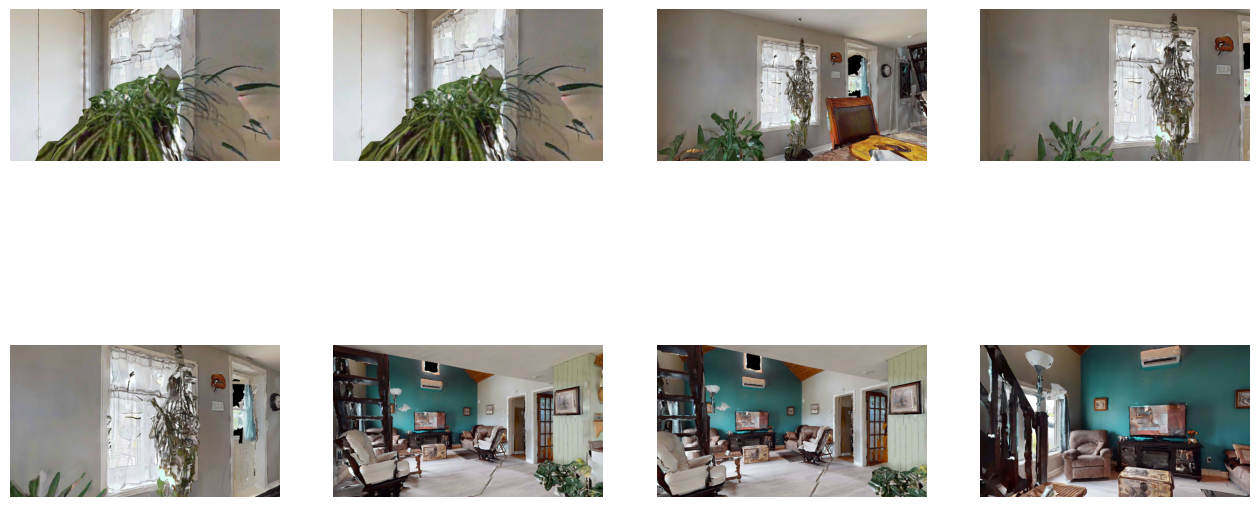

In [27]:
# display frames in 4x2 grid
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    ax[i // 4, i % 4].imshow(video[i])
    ax[i // 4, i % 4].axis('off')
plt.show()

In [39]:
inputs = processor(text=prompt, videos=video, return_tensors="pt")

In [40]:
out = model.generate(**inputs, max_new_tokens=40)
print(processor.batch_decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True))

['USER: What is in between the two picture frames on the blue wall in the living room? ASSISTANT: There is a television in between the two picture frames on the blue wall in the living room.Ъ']


In [41]:
spatial_hm3d.iloc[0].answer

'The TV'

In [9]:
# create new column for responses:
spatial_hm3d['response'] = None

for index, row in spatial_hm3d.iterrows():
    prompt = f"USER: <video>{row.question} ASSISTANT:"
    ep_history = row.episode_history
    video = load_images_to_array(f'data/frames/{ep_history}')
    inputs = processor(text=prompt, videos=video, return_tensors="pt")
    out = model.generate(**inputs, max_new_tokens=40)
    response = processor.batch_decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    print(f"Question: {row.question}")
    print(f"Answer: {row.answer}")
    print(f"Assistant: {response}")
    # add response to dataframe
    spatial_hm3d.loc[index, 'response'] = response[0]

C:\Users\Bridget Leonard\AppData\Local\Temp\ipykernel_25524\2387385709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_hm3d['response'] = None


Number of frames:  99
Selected indices:  [ 0 12 24 37 49 61 74 86]


c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(value)


Question: What is in between the two picture frames on the blue wall in the living room?
Answer: The TV
Assistant: ['USER: What is in between the two picture frames on the blue wall in the living room? ASSISTANT: There is a television in between the two picture frames on the blue wall in the living room.Ъ']
Number of frames:  99
Selected indices:  [ 0 12 24 37 49 61 74 86]
Question: Is there room on the dining table to eat?
Answer: Yes
Assistant: ['USER: Is there room on the dining table to eat? ASSISTANT: Yes, there is room on the dining table to eat.Ъ']
Number of frames:  120
Selected indices:  [  0  15  30  45  60  75  90 105]
Question: What is to the left of the mirror?
Answer: A plant in a tall vase
Assistant: ['USER: What is to the left of the mirror? ASSISTANT: A door is to the left of the mirror.Ъ']
Number of frames:  120
Selected indices:  [  0  15  30  45  60  75  90 105]
Question: What is to the left of the staircase?
Answer: A storage closet
Assistant: ['USER: What is to th

In [10]:
spatial_hm3d.head()

,question,answer,category,question_id,episode_history,extra_answers,response
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,USER: What is in between the two picture frame...
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,USER: Is there room on the dining table to eat...
13,What is to the left of the mirror?,A plant in a tall vase,spatial understanding,b6dcf043-30a6-4b4e-9787-9b29bd1b1703,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,USER: What is to the left of the mirror? ASSIS...
14,What is to the left of the staircase?,A storage closet,spatial understanding,5460114d-e885-4eae-8bdc-a273deb3df0a,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,USER: What is to the left of the staircase? AS...
22,What is on the top shelf to the right side of ...,An ice cooler,spatial understanding,9b4a7fbb-680d-4e39-8d60-7b1e521f3108,hm3d-v0/002-hm3d-wcojb4TFT35,NaN,USER: What is on the top shelf to the right si...


In [13]:
spatial_hm3d.to_csv('data/spatial_hm3d_responses.csv', index=False)

In [12]:
# Clean response column to only get text after 'ASSISTANT:'
spatial_hm3d['response'] = spatial_hm3d['response'].str.split('ASSISTANT:').str[-1].str.strip()
spatial_hm3d.head()

C:\Users\Bridget Leonard\AppData\Local\Temp\ipykernel_25524\746115340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_hm3d['response'] = spatial_hm3d['response'].str.split('ASSISTANT:').str[-1].str.strip()


,question,answer,category,question_id,episode_history,extra_answers,response
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,There is a television in between the two pictu...
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,"Yes, there is room on the dining table to eat.Ъ"
13,What is to the left of the mirror?,A plant in a tall vase,spatial understanding,b6dcf043-30a6-4b4e-9787-9b29bd1b1703,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,A door is to the left of the mirror.Ъ
14,What is to the left of the staircase?,A storage closet,spatial understanding,5460114d-e885-4eae-8bdc-a273deb3df0a,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,A door is to the left of the staircase.Ъ
22,What is on the top shelf to the right side of ...,An ice cooler,spatial understanding,9b4a7fbb-680d-4e39-8d60-7b1e521f3108,hm3d-v0/002-hm3d-wcojb4TFT35,NaN,There is a bag of garbage on the top shelf to ...


## Create an LLM to judge 'correctness' of responses

In [31]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained model for semantic textual similarity
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

def evaluate_answer(human_answer, model_answer, extra_answers=None):
    # Compute embeddings for the main human answer and model answer
    embeddings_human = model.encode(human_answer, convert_to_tensor=True)
    embeddings_model = model.encode(model_answer, convert_to_tensor=True)
    
    # Initialize a list to store scores, starting with the main answer's score
    scores = [util.pytorch_cos_sim(embeddings_human, embeddings_model).item()]

    # Compute scores for extra answers if they exist
    if not pd.isna(extra_answers):
        print(extra_answers)
        for extra in extra_answers:
            embeddings_extra = model.encode(extra, convert_to_tensor=True)
            score = util.pytorch_cos_sim(embeddings_model, embeddings_extra).item()
            scores.append(score)
    
    # Take the maximum score from all considered answers
    max_score = max(scores)
    
    # Convert the maximum cosine similarity score (0 to 1) to a 1 to 5 scale
    llm_score = 1 + (max_score * 4)
    return llm_score

c:\Users\Bridget Leonard\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
spatial_hm3d.columns

Index(['question', 'answer', 'category', 'question_id', 'episode_history',
       'extra_answers', 'response'],
      dtype='object')

In [32]:
# Apply the evaluation function
spatial_hm3d['LLM_Score'] = spatial_hm3d.apply(lambda x: evaluate_answer(x['answer'], x['response'], x['extra_answers']), axis=1)

C:\Users\Bridget Leonard\AppData\Local\Temp\ipykernel_25524\946330076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spatial_hm3d['LLM_Score'] = spatial_hm3d.apply(lambda x: evaluate_answer(x['answer'], x['response'], x['extra_answers']), axis=1)


In [33]:
spatial_hm3d.head()

,question,answer,category,question_id,episode_history,extra_answers,response,LLM_Score
3,What is in between the two picture frames on t...,The TV,spatial understanding,c841bb52-1cec-46d7-bb83-8c99b5c66fa8,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,There is a television in between the two pictu...,3.427967
4,Is there room on the dining table to eat?,Yes,spatial understanding,79344680-6b45-4531-8789-ad0f5ef85b3b,hm3d-v0/000-hm3d-BFRyYbPCCPE,NaN,"Yes, there is room on the dining table to eat.Ъ",2.469342
13,What is to the left of the mirror?,A plant in a tall vase,spatial understanding,b6dcf043-30a6-4b4e-9787-9b29bd1b1703,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,A door is to the left of the mirror.Ъ,1.710656
14,What is to the left of the staircase?,A storage closet,spatial understanding,5460114d-e885-4eae-8bdc-a273deb3df0a,hm3d-v0/001-hm3d-TPhiubUHKcP,NaN,A door is to the left of the staircase.Ъ,3.092149
22,What is on the top shelf to the right side of ...,An ice cooler,spatial understanding,9b4a7fbb-680d-4e39-8d60-7b1e521f3108,hm3d-v0/002-hm3d-wcojb4TFT35,NaN,There is a bag of garbage on the top shelf to ...,2.453496


In [35]:
total_score = spatial_hm3d['LLM_Score'].sum() / (spatial_hm3d.shape[0] * 5)
total_score

0.5242401970253474

## LLaVA NeXT Video

In [5]:
# Load model directly
from transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained("lmms-lab/LLaVA-NeXT-Video-7B")
model = AutoModelForCausalLM.from_pretrained("lmms-lab/LLaVA-NeXT-Video-7B")

OSError: lmms-lab/LLaVA-NeXT-Video-7B does not appear to have a file named preprocessor_config.json. Checkout 'https://huggingface.co/lmms-lab/LLaVA-NeXT-Video-7B/tree/main' for available files.